In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install yt-dlp opencv-python-headless deepface google-api-python-client

Engagement Score Computation - mix of Likes, Views and Comments

In [5]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('video_data_final (128vids).csv')

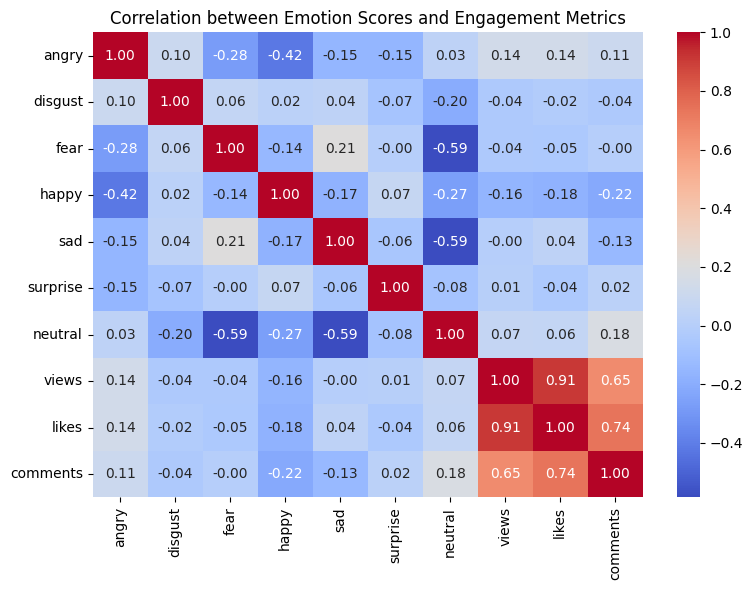

In [6]:
# Select emotion and metric columns
emotion_cols = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
metric_cols = ['views', 'likes', 'comments']

# Compute correlation matrix between emotions and engagement metrics
corr_matrix = df[emotion_cols + metric_cols].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation between Emotion Scores and Engagement Metrics")
plt.tight_layout()
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['views_norm', 'likes_norm', 'comments_norm']] = scaler.fit_transform(df[['views', 'likes', 'comments']])

df['engagement_score'] = 0.3 * df['likes_norm'] + 0.2 * df['comments_norm'] + 0.5 * df['views_norm']

In [8]:
# aggregations of facial expression and of title senitment
df['pos_emotion'] = df['happy'] + df['surprise']
df['neg_emotion'] = df['angry'] + df['disgust'] + df['fear'] + df['sad']
df['emotional_intensity'] = 1 - (df['neutral'] / 100)


df['title_sentiment'] = (
    df['title is exaggerated'] +
    df['title is emotionally touching'] -
    df['title is plain']
)

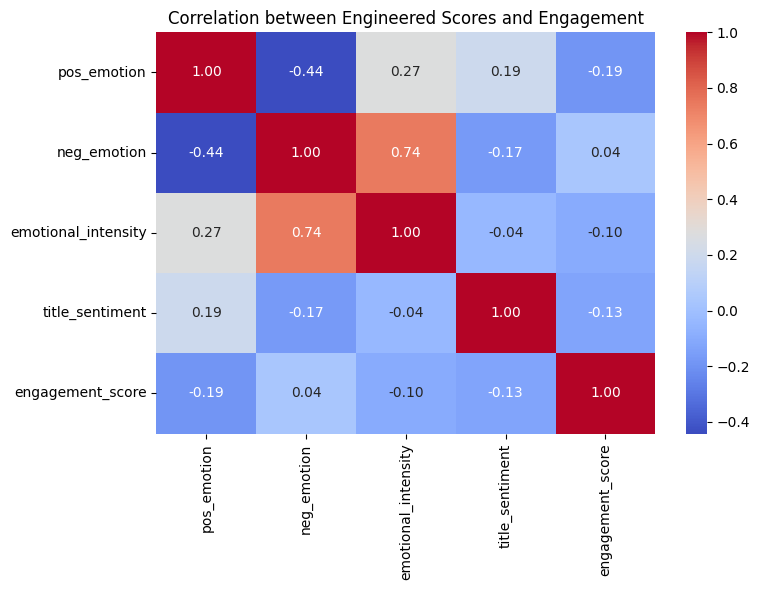

In [9]:
engineered_emotions = ['pos_emotion', 'neg_emotion', 'emotional_intensity']

corr_matrix = df[engineered_emotions + ['title_sentiment'] + ['engagement_score']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation between Engineered Scores and Engagement")
plt.tight_layout()
plt.show()

In [10]:
import statsmodels.api as sm

X = df[[#'pos_emotion',
        #'neg_emotion',
        'emotional_intensity',
        'title_sentiment',
        'pct_with_face'#,
        #'brightness',
        #'blurriness'
        ]]

y = df['engagement_score']


model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       engagement_score   R-squared (uncentered):                   0.494
Model:                            OLS   Adj. R-squared (uncentered):              0.481
Method:                 Least Squares   F-statistic:                              40.61
Date:                Tue, 13 May 2025   Prob (F-statistic):                    2.16e-18
Time:                        08:51:49   Log-Likelihood:                          117.05
No. Observations:                 128   AIC:                                     -228.1
Df Residuals:                     125   BIC:                                     -219.5
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
emotional_intensity     0.0724      0.027      2.715      0.008       0.020       0.125
title_sentiment        -0.0331      0.021     -1.551      0.123      -0.075       0.009
pct_with_face           0.0013      0.000      3.023      0.003       0.000       0.002
==============================================================================
Omnibus:                      202.374   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16893.231
Skew:                           6.407   Prob(JB):                         0.00
Kurtosis:                      57.802   Cond. No.                         131.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Option 2: Use PCA at cost of interpretability and explanatory power

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('video_data_final (128vids).csv')

emotion_cols = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
metric_cols = ['views', 'likes', 'comments']
title_cols = ['title is exaggerated', 'title is emotionally touching', 'title is plain']

df['pos_emotion'] = df['happy'] + df['surprise']
df['neg_emotion'] = df['angry'] + df['disgust'] + df['fear'] + df['sad']

scaler = StandardScaler()
# scaling extracted features for pca
emotion_scaled = scaler.fit_transform(df[emotion_cols])
title_scaled = scaler.fit_transform(df[title_cols])

# scaling metadata and constructing engagement score for later analysis
df[['views_norm', 'likes_norm', 'comments_norm']] = scaler.fit_transform(df[metric_cols])
df['engagement_score'] = 0.5 * df['views_norm'] + 0.2 * df['likes_norm'] + 0.3 * df['comments_norm']


# pca on emotions - reduce into single dimension
pca = PCA(n_components=1)
emotion_pca = pca.fit_transform(emotion_scaled)


pca_cols = [f'emotion_pca_{i+1}' for i in range(emotion_pca.shape[1])]
df_pca = pd.DataFrame(emotion_pca, columns=pca_cols, index=df.index)
df = pd.concat([df, df_pca], axis=1)


# pca on title sentiment to vectorize senitment scores into one
title_pca = pca.fit_transform(title_scaled)
df['title_pca'] = title_pca


df.head()

,video_id,video_title,published_at,playlist_name,playlist_id,video_url,channel_title,views,likes,comments,...,title is emotionally touching,title is exaggerated,pos_emotion,neg_emotion,views_norm,likes_norm,comments_norm,engagement_score,emotion_pca_1,title_pca
0,EnhXwiPC3rE,New York City Lunch Crisis,2025-05-06 18:19:45+00:00,Uploads,UUtinbF-Q-fVthA0qrFQTgXQ,https://www.youtube.com/watch?v=EnhXwiPC3rE,CaseyNeistat,550434,44188,2443,...,0.285810,0.210855,19.597481,48.546030,-0.563072,-0.694913,-0.714373,-0.634831,-0.204982,1.000586
1,Ud2BcD5NC2A,The IMPOSSIBLE Camera,2025-04-22 12:21:40+00:00,Uploads,UUtinbF-Q-fVthA0qrFQTgXQ,https://www.youtube.com/watch?v=Ud2BcD5NC2A,CaseyNeistat,1207258,62164,2758,...,0.044744,0.747286,12.920556,41.511087,-0.398322,-0.498234,-0.637548,-0.490072,1.975425,-1.863298
2,AjKGToaFDvA,the very WORST Nintendo Switch 2 review.,2025-04-04 17:30:56+00:00,Uploads,UUtinbF-Q-fVthA0qrFQTgXQ,https://www.youtube.com/watch?v=AjKGToaFDvA,CaseyNeistat,1169680,47699,2229,...,0.007422,0.373725,12.588948,50.924923,-0.407747,-0.656498,-0.766566,-0.565143,-0.057824,0.876013
3,StMltAX0mp0,DO HARD THINGS,2024-11-14 18:49:01+00:00,Uploads,UUtinbF-Q-fVthA0qrFQTgXQ,https://www.youtube.com/watch?v=StMltAX0mp0,CaseyNeistat,3049655,143601,4906,...,0.239816,0.459557,21.921864,53.634263,0.063805,0.392782,-0.113669,0.076358,-0.955172,-0.565947
4,TUbIKg-lrow,New York City's Controversial Fire Hydrant Fis...,2024-09-23 15:29:37+00:00,Uploads,UUtinbF-Q-fVthA0qrFQTgXQ,https://www.youtube.com/watch?v=TUbIKg-lrow,CaseyNeistat,1982683,79572,4107,...,0.251280,0.393493,20.649047,51.454034,-0.203822,-0.307771,-0.308538,-0.256027,-0.588407,-0.147084


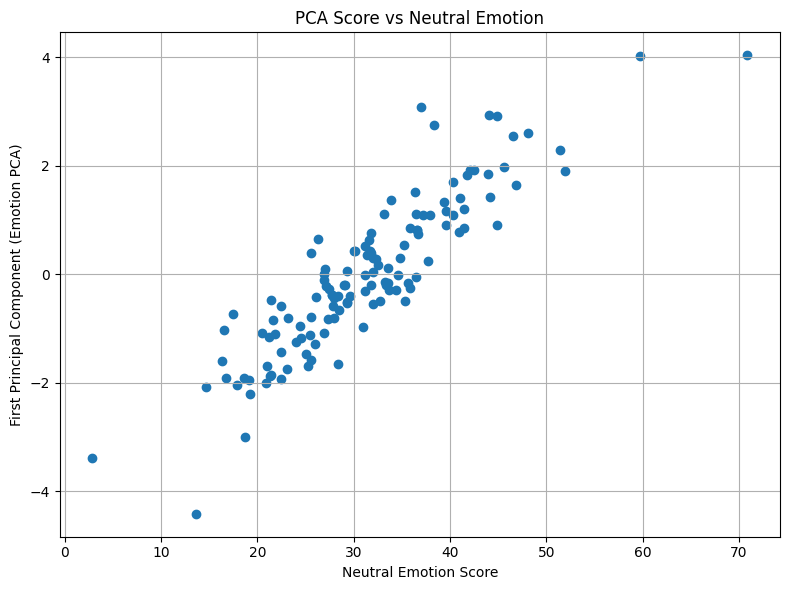

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(df['neutral'], df['emotion_pca_1'])
plt.xlabel('Neutral Emotion Score')
plt.ylabel('First Principal Component (Emotion PCA)')
plt.title('PCA Score vs Neutral Emotion')
plt.grid(True)
plt.tight_layout()
plt.show()


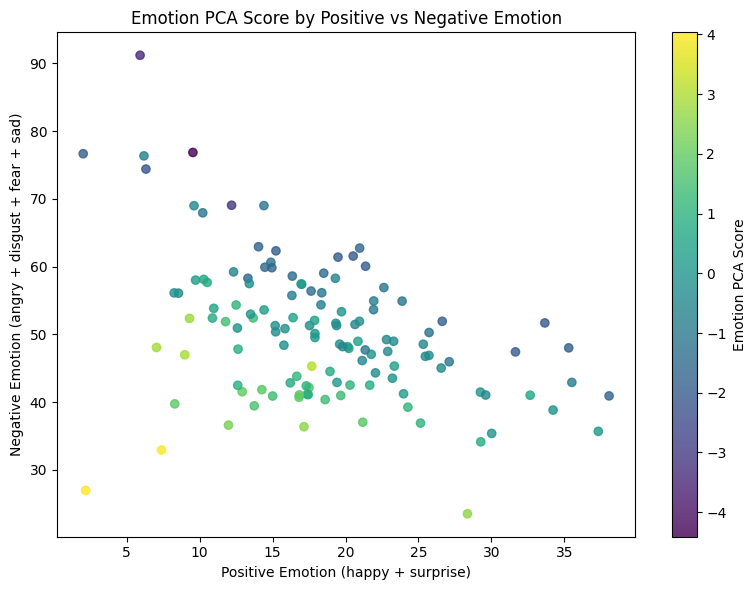

In [27]:
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    df['pos_emotion'],
    df['neg_emotion'],
    c=df['emotion_pca_1'],
    alpha=0.8
)
plt.xlabel('Positive Emotion (happy + surprise)')
plt.ylabel('Negative Emotion (angry + disgust + fear + sad)')
plt.title('Emotion PCA Score by Positive vs Negative Emotion')
cbar = plt.colorbar(sc)
cbar.set_label('Emotion PCA Score')
plt.tight_layout()
plt.show()

<ipython-input-31-33e859e00656>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(


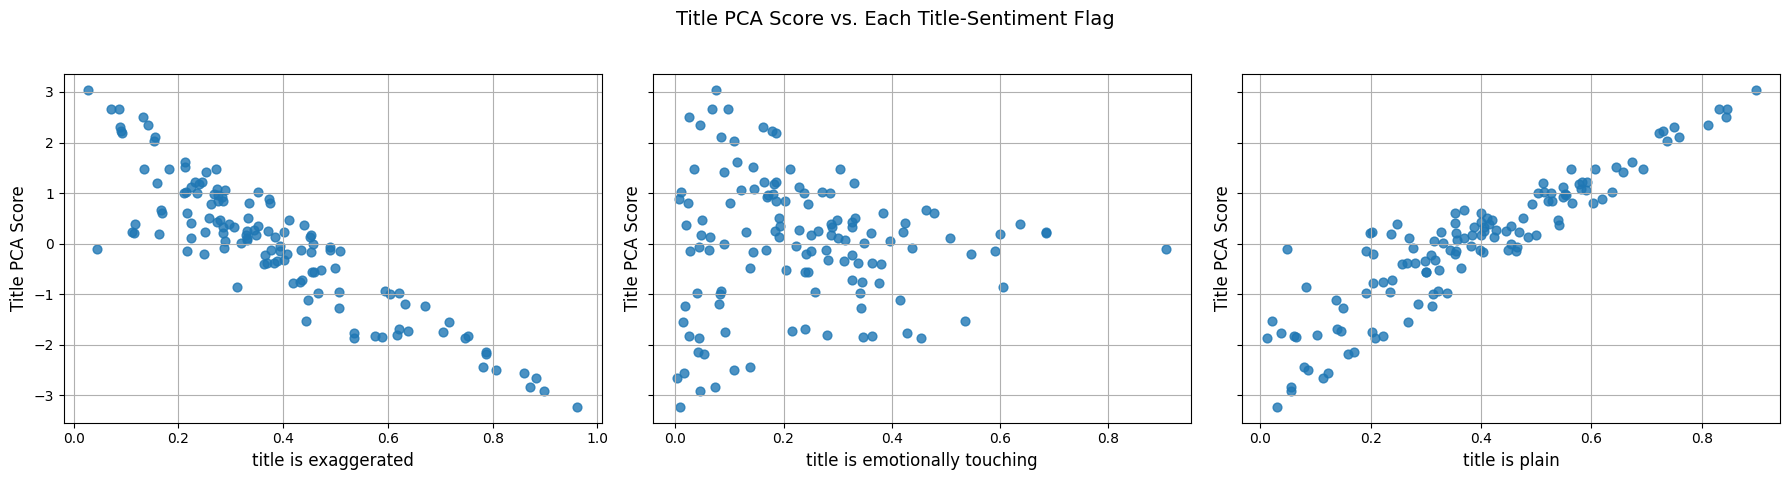

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, col in zip(axes, title_cols):
    sc = ax.scatter(
        df[col],
        df['title_pca'],
        cmap='viridis',
        alpha=0.8,
        s=40
    )
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Title PCA Score', fontsize=12)
    ax.grid(True)


plt.suptitle('Title PCA Score vs. Each Title-Sentiment Flag', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [32]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X_cols = ['emotion_pca_1',
          'title_pca',
          'pct_with_face'
          ]

# lin reg on egagement score (egagement = views & likes)
X = df[X_cols]
y = df['engagement_score']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       engagement_score   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.781
Date:                Tue, 13 May 2025   Prob (F-statistic):              0.154
Time:                        09:23:55   Log-Likelihood:                -168.30
No. Observations:                 128   AIC:                             344.6
Df Residuals:                     124   BIC:                             356.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2844      0.218     -1.307      0.194      -0.715       0.146
emotion_pca_1     0.0463      0.065      0.716      0.476      -0.082       0.174
title_pca         0.0721      0.064      1.125      0.263      -0.055       0.199
pct_with_face     0.0075      0.005      1.408      0.162      -0.003       0.018
==============================================================================
Omnibus:                      207.499   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18997.075
Skew:                           6.671   Prob(JB):                         0.00
Kurtosis:                      61.172   Cond. No.                         113.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""